# <font color=#135CB3>Projet 8 - Participez à la conception d'une voiture autonome</font>
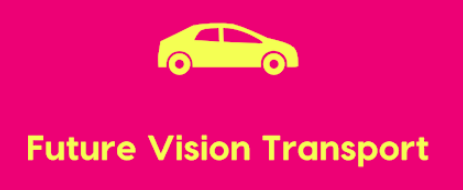

<div style="text-align:center">
<div style="background-color: #6DE9FD">
<div style = "border: 3px blue groove">
<h1>
<b>Partie B: Modélisation</b><br>
</h1>
</div>
</div>
</div>

## <font color=#009BFA> Objectif du projet</font>
- **Concevoir un premier modèle de segmentation d’images**

## <font color=#009BFA> Plan :</font>
- **Identification de la cible**
- **Métrique d'évaluation**
    - Score IoU
    - Temps d'exécution et nombre de paramètres
- **Augmentation des données**
    - Séquence de transformation de l'image
    - Image et masque de test original avant augmentation
    - Essai de deux versions d'augmentation
    - Augmentation de l'image et masque de test original
    - Image et masque de test original après augmentation
- **Générateur de données**
    - Générateur sans augmentation des images
    - Générateur avec augmentation des images à la volée    
- **Modélisation**    
    - Modélisation "from scratch" avec Keras
    - Modélisation avec la librairie **segmentation-models** 
    - Optimisation des hyperparamètres : 
        - Optimisation de la fonction de perte
        - Optimisation du Backbone
        - Optimisation de l'architecture du réseau
        - Conclusion : meilleur modèle retenu
- **Evaluation du meilleur modèle sur le jeu de test**
    - Chargement du meilleur modèle
    - Générateur et preprocessing pour le jeu de test
    - Prédictions sur le jeu de test
    - Calcul du Score IoU sur le jeu de test
    - Conclusion de l'évaluation sur le jeu de test

# <font color=#009BFA> Montage drive</font>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os

In [ ]:
os.chdir("/gdrive/MyDrive/P8/")
!ls

checkpoints  models  notebooks	outputs  prepared_data


In [3]:
drive_path = "/gdrive/MyDrive/P8/"

## Installation modules suplémentaires

In [4]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.1 MB/s 


In [5]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-xxgle7ih
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-xxgle7ih


# <font color=#009BFA>Importation des librairies nécessaires</font>

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import albumentations as A

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [9]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [10]:
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs:  1


In [11]:
!nvidia-smi

Tue Aug 16 11:24:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <span style='color:blue' id="section_1" >1.  Identification de la cible</span>

- L'objectif de ce projet est de faire de la segmentation d'images, c'est-à-dire procéder à un classement de chaque pixel d’une image selon sa catégorie.
- Pour cela, il faut prédire à quelle catégorie appartient chaque pixel de l'image originale.
- **L'ensemble des prédictions de l'appartenance des pixels aux catégories va former une image que l'on appelle un masque.**
- <font color=#C55100>**La cible à prédire, appelé `label`, est donc le masque de chaque image qui correspond à la catégorie de chaque pixel de l'image (nature, ciel, humain, véhicule, vide, construction, objet, plat).**</font>
- Pour chaque image en entrée, il faut donc prédire son masque.

# <span style='color:blue' id="section_2" >2. Métrique d'évaluation</span>

- La métrique d’évaluation habituellement utilisée dans les problèmes de la classification est l’`Accuracy`. Cette métrique n’est pas adaptée à des jeux de données déséquilibrés comme c’est le cas pour la segmentation d’images
- Nous avons retenu la métrique **Mean IoU Score** pour évaluer nos modèles. Ce score correspond à la moyenne du coefficient **Intersection over Union** des différentes catégories. Le coefficient Intersection over Union est défini comme la zone de chevauchement (overlap) entre la segmentation prédite et la segmentation réelle divisé par la zone d’union entre la segmentation prédite et la segmentation réelle.
- La métrique Mean IoU Score est particulièrement bien adaptée à la segmentation d'images.
- Le score est compris entre 0 et 1 et plus on s’approche de 1 plus la similarité entre la prédiction et la réalité est élevée.


- En plus de cette mesure, nous allons également prendre en compte :
    - Le **Temps d'exécution** des différents modèles.
    - Le **Nombre de paramètres** des réseaux des différents modèles.

# <span style='color:blue' id="section_3" >3. Augmentation des données</span>

- L'augmentation des données nous permet de générer de nouvelles images à partir des images originales.
- Cela permet d'améliorer l'apprentissage.
- Nous avons utilisé la librairie `Albumentations` pour l'augmentation des images.


- Nous avons testé **deux types** d'augmentation d'images :
    - Une première version `SOFT` qui utilise **trois techniques d'augmentation** :
        - 1 : Horizontal Flip : basculement horizontal de l'image.
        - 2 : Random Gamma : modification aléatoire du gamma.
        - 3 : Blur : ajout de bruit.
        - Chacune des trois techniques d'augmentation a **une probabilité de 0.25 d'être appliquée**
    - Une seconde version plus `HARD` qui utilise **six techniques d'augmentation** :    
        - 1 : Elastic Transform : transformation élastique.
        - 2 : Horizontal Flip : basculement horizontal.
        - 3 : Grid Distortion : distorsion de l'image.
        - 4 : Random Gamma : modification aléatoire du gamma.
        - 5 : Emboss : ciselage de l'image.
        - 6 : Blur : ajout de bruit. 
        - Chacune des six techniques d'augmentation a **une probabilité de 0.5 d'être appliquée**

- **La seconde version transforme plus les images que la première** : le nombre de modifications et la probabilité d'application sont plus élevés


- Ci-dessous se trouve un essai d'augmentation test sur une image pour chaque version
> <font color=#5D4D43>**Remarque : Les augmentations ci-dessous sont des exemples permettant de visualiser les transformations sur un exemple, l'augmentation des images pour la modélisation se fera à la volée dans le générateur de données.**</font>

>## <span style='color:green' id="section_3_1" >3.1. Image et masque de test original avant augmentation</span>

In [ ]:
image = load_img("/gdrive/MyDrive/P8/prepared_data/0.png", target_size=(256, 512))

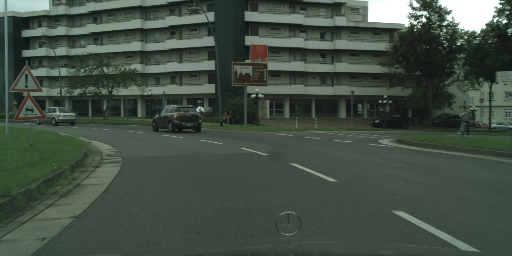

In [ ]:
image

In [ ]:
mask = load_img("/gdrive/MyDrive/P8/prepared_data/0.png", target_size=(256, 512))

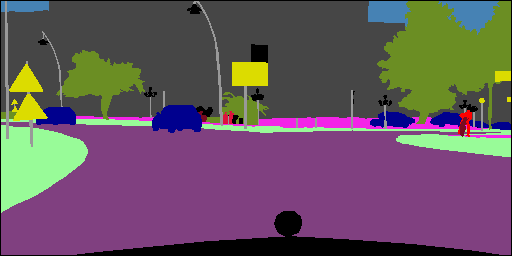

In [ ]:
mask

In [ ]:
img_array = img_to_array(image)

In [ ]:
mask_array = img_to_array(mask)

## <span style='color:green' id="section_3_2" >3.2. Augmentation version Soft</span>

### Séquence de transformation de l'image

In [ ]:
transform_v1 = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomGamma(p=1),
    A.Blur(p=1, blur_limit = 7)
])

### Augmentation de l'image et masque de test original

In [ ]:
transformed_v1 = transform_v1(image=img_array, mask=mask_array)

In [ ]:
transformed_image_array_v1 = transformed_v1['image']

In [ ]:
transformed_image_v1 = array_to_img(transformed_image_array_v1)

In [ ]:
transformed_mask_array_v1 = transformed_v1['mask']

In [ ]:
transformed_mask_v1 = array_to_img(transformed_mask_array_v1)

### Image et masque de test original après augmentation

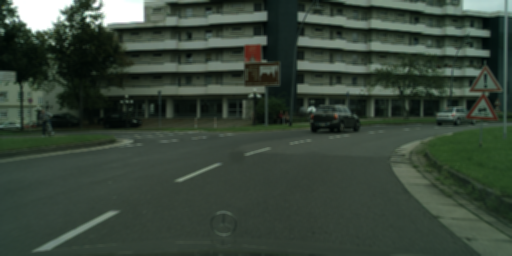

In [ ]:
transformed_image_v1

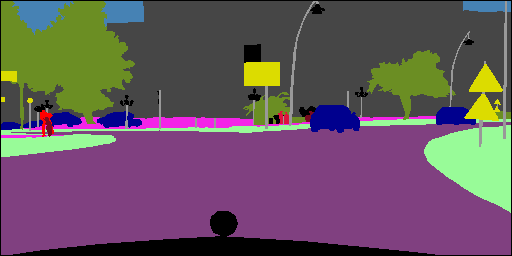

In [ ]:
transformed_mask_v1

### Synthèse :
- L'essai d'augmentation d'image a bien fonctionné pusiqu'on remarque sur l'image et le masque de test les transformations appliquées :
    - l'inversion horizontal de l'image
    - un changement de contraste
    - un flou provenant de l'ajout d'un bruit

## <span style='color:green' id="section_3_3" >3.3. Augmentation version HARD</span>

### Séquence de transformation de l'image

In [ ]:
transform_v2 = A.Compose([
        A.ElasticTransform(p=1),
        A.HorizontalFlip(p=1),
        A.GridDistortion(p=1),
        A.RandomGamma(p=1),
        A.Emboss(p=1),
        A.Blur(p=1, blur_limit = 7)
])

### Augmentation de l'image et masque de test original

In [ ]:
transformed_v2 = transform_v2(image=img_array, mask=mask_array)

In [ ]:
transformed_image_array_v2 = transformed_v2['image']

In [ ]:
transformed_image_v2 = array_to_img(transformed_image_array_v2)

In [ ]:
transformed_mask_array_v2 = transformed_v2['mask']

In [ ]:
transformed_mask_v2 = array_to_img(transformed_mask_array_v2)

### Image et masque de test original après augmentation

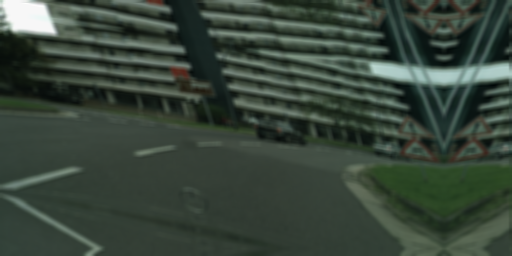

In [ ]:
transformed_image_v2

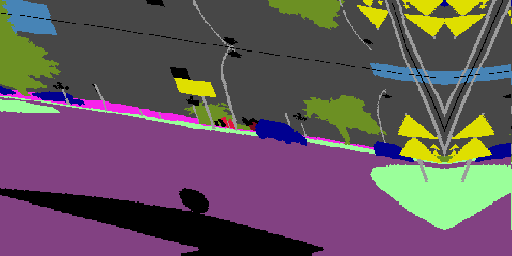

In [ ]:
transformed_mask_v2

### Synthèse :
- L'essai d'augmentation d'image a bien fonctionné et on remarque que les transformations sont plus conséquentes que la première version.

# <span style='color:blue' id="section_4" >4. Générateur de données</span>

- Le générateur de données va nous permettre de générer des images à la volée, en batch.
- Cela permet de traiter des données volumineuses comme c'est le cas ici.
- Pour implémenter un générateur de données sur mesure, nous dérivons la class Keras `Sequence`.
- La **normalisation** des données est également effectuée dans le générateur de données.

>## <span style='color:green' id="section_4_1" >4.1  Fonctions permettant de transformer les données</span>

In [ ]:
# Augmentation des données : version Soft
def img_aug_v1():
    transform = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.RandomGamma(p=0.25),
        A.Blur(p=0.25, blur_limit = 7)
    ])
    return transform

In [ ]:
# Augmentation des données : version Hard
def img_aug_v2():
    transform = A.Compose([
           A.ElasticTransform(p=0.5),
           A.HorizontalFlip(p=0.5),
           A.GridDistortion(p=0.5),
           A.RandomGamma(p=0.5),
           A.Emboss(p=0.5),
           A.Blur(p=0.5, blur_limit = 7)
    ])
    return transform

In [ ]:
# Fonction de preprocessing
def get_preprocessing(preprocessing_fn):   
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

>## <span style='color:green' id="section_4_2" >4.2 Générateur de données AVEC et SANS augmentation des images à la volée</span>

- L'augmenteur de données est créé grâce à la librairie Albumentations et transmis en paramètre du générateur

In [ ]:
# Génération des données SANS préprocessing

class DataGeneratorKeras_aug(Sequence):

    def __init__(self, batch_size, img_size, input_img_dir, target_img_dir, augmentation_sequence=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_dir = input_img_dir
        self.input_img_paths = sorted(os.listdir(input_img_dir))
        self.target_img_dir = target_img_dir
        self.target_img_paths = sorted(os.listdir(target_img_dir))
        self.augmentation_sequence = augmentation_sequence

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
                
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="float32")
        
        if self.augmentation_sequence is not None:
            for j in range(len(batch_input_img_paths)):
                #traitement des images
                input_path = batch_input_img_paths[j]
                img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
                img_array = img_to_array(img)

                #traitement des masques
                target_path = batch_target_img_paths[j]
                mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
                #mask_traite = img_map_ids(mask)
                mask_array = img_to_array(mask)
                
                augmented_data = self.augmentation_sequence(image=img_array, mask=mask_array)

                x[j] = augmented_data['image'] / 255. #normalisation des données
                y[j] = tf.one_hot(np.squeeze(augmented_data['mask']), 8, on_value=1.0, off_value=0.0, axis=-1)
        
        else:
            #traitement des images
            for j, input_path in enumerate(sorted(batch_input_img_paths)):
                img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
                img_array = img_to_array(img)
                x[j] = img_array / 255. #normalisation des données
        
            #traitement des masques
            for j, target_path in enumerate(sorted(batch_target_img_paths)):
                mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
                #mask_traite = img_map_ids(mask)
                mask_array = img_to_array(mask)
                y[j] = tf.one_hot(np.squeeze(mask_array), 8, on_value=1.0, off_value=0.0, axis=-1)
        
        return x, y


In [ ]:
# Génération des données AVEC préprocessing

class DataGeneratorKeras_augm_preproc(Sequence):

    def __init__(self, batch_size, img_size, input_img_dir, target_img_dir, augmentation_sequence=None, preprocessing=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_dir = input_img_dir
        self.input_img_paths = sorted(os.listdir(input_img_dir))
        self.target_img_dir = target_img_dir
        self.target_img_paths = sorted(os.listdir(target_img_dir))
        self.augmentation_sequence = augmentation_sequence
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
                
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="float32")
        
        if self.augmentation_sequence is not None:
            for j in range(len(batch_input_img_paths)):
                #traitement des images
                input_path = batch_input_img_paths[j]
                img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
                img_array = img_to_array(img)

                #traitement des masques
                target_path = batch_target_img_paths[j]
                mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
                mask_array = img_to_array(mask)

                #augmentation et preprocessing
                augmented_data = self.augmentation_sequence(image=img_array, mask=mask_array)
                augmented_preprocessed_image = self.preprocessing(image=augmented_data['image'])
                    
                x[j] = augmented_preprocessed_image['image']
                y[j] = tf.one_hot(np.squeeze(augmented_data['mask']), 8, on_value=1.0, off_value=0.0, axis=-1)
        
        else:
            #traitement des images
            for j, input_path in enumerate(sorted(batch_input_img_paths)):
                img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
                img_array = img_to_array(img)
                preprocessed_image = self.preprocessing(image=img_array)
                x[j] = preprocessed_image['image']
        
            #traitement des masques
            for j, target_path in enumerate(sorted(batch_target_img_paths)):
                mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
                mask_array = np.squeeze(img_to_array(mask))
                y[j] = tf.one_hot(mask_array, 8, on_value=1.0, off_value=0.0, axis=-1)

        return x, y


>## <span style='color:#5D4D43' >Fonctions permettant de tracer les courbes de Loss et IoU Score en fonction du nombre d'epochs</span>

In [ ]:
def plot_loss(entree):
    plt.figure()
    plt.plot(entree.history['loss'])
    plt.plot(entree.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.title("Evolution de la Loss en fonction du nombre d'epochs")
    plt.show()

In [ ]:
def plot_iou(entree):
    plt.figure()
    plt.plot(entree.history['iou_score'])
    plt.plot(entree.history['val_iou_score'])
    plt.legend(['Train', 'Validation'])
    plt.title("Evolution du Score IoU en fonction du nombre d'epochs")
    plt.show()
       

 # <span style='color:blue' id="section_5" >5. Modélisation</span>

- Les modélisations que nous allons implémenter peuvent être regroupées en 2 catégories :
    - Modélisation **"from scratch"** : les modèles sont implémentés ‘à la main’ en utilisant l'API fonctionnelle de Keras.
>Cette première approche permet de bien comprendre et appréhender les modèles et l'API Keras.

    - Modélisation utilisant la librairie **"segmentation-models"** : cette librairie Python, qui s’appuie sur Keras, contient des modèles, des métriques et des fonctions de coût dédiés à la segmentation.
> Cette seconde approche permet d'utiliser des modèles plus avancés, ainsi que des fonctions de coût différentes déjà implémentées.


<span style='color:#017E86'>**Pour l'entraînement des modèles nous avons réduit la taille des images afin d'avoir des temps de calcul raisonnable et également pour tenir compte de la capacité mémoire du matériel que nous avons à notre disposition.**</span>

>## <span style='color:#5D4D43' >Etablissement du chemin des images et leurs masks</span>

In [ ]:
# Données
image_dataset_train_dir = drive_path + 'prepared_data/images/train/'
mask_dataset_train_dir = drive_path +'prepared_data/masks_traites/train/'
image_dataset_val_dir = drive_path + 'prepared_data/images/val/'
mask_dataset_val_dir = drive_path + 'prepared_data/masks_traites/val/'

>## <span style='color:#5D4D43' >Paramètres généraux des modèles</span>

In [ ]:
# Paramètres
nb_epochs = 20
batch_size = 16
img_size = (128, 256)
num_cats = 8

>## <span style='color:green' id="section_5_1" >5.1 Modélisation from scratch `"fs"` en utilisant Keras</span>
>## <span style='color:#835A00' id="section_5_1"> Définition de l'architecture U-Net</span>

In [ ]:
# Modèle
def get_unet_model(img_size, num_cats):
    inputs = layers.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # 256*256*64
    
    x1 = layers.MaxPooling2D(padding='same')(x) # 128*128*64
    
    x1 = layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)  # 128*128*128
    
    x2 = layers.MaxPooling2D(padding='same')(x1) # 64*64*128
    
    x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)  # 64*64*256
    
    x3 = layers.MaxPooling2D(padding='same')(x2) # 32*32*256
    
    x3 = layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = layers.BatchNormalization()(x3)  # 32*32*512
    
    x4 = layers.MaxPooling2D(padding='same')(x3) # 16*16*512
    
    x4 = layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = layers.BatchNormalization()(x4)  # 16*16*1024
    
    x5 = layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu')(x4)
    x5 = layers.BatchNormalization()(x5)  # 32*32*512
    
    x6 = layers.concatenate([x3, x5], axis=-1) # 32*32*1024
    
    x6 = layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = layers.BatchNormalization()(x6)  # 32*32*512
    
    x7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same', activation='relu')(x6)
    x7 = layers.BatchNormalization()(x7)  # 64*64*256
    
    x8 = layers.concatenate([x2, x7], axis=-1) # 64*64*512
    
    x8 = layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = layers.BatchNormalization()(x8)  # 64*64*256
    
    x9 = layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu')(x8)
    x9 = layers.BatchNormalization()(x9)  # 128*128*128
    
    x10 = layers.concatenate([x1, x9], axis=-1) # 128*128*256
    
    x10 = layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = layers.BatchNormalization()(x10)  # 128*128*128
    
    x11 = layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(x10)
    x11 = layers.BatchNormalization()(x11)  # 256*256*64
    
    x12 = layers.concatenate([x, x11], axis=-1) # 256*256*128
    
    x12 = layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = layers.BatchNormalization()(x12)
    x12 = layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = layers.BatchNormalization()(x12)  # 256*256*64
    
    outputs = layers.Conv2D(num_cats, 1, activation='softmax')(x12) # 256*256*34
    
    return Model(inputs=inputs, outputs=outputs)


>## <span style='color:#CA0000' id="section_5_1_1">5.1.1. Architecture U-Net `&` SANS augmentation des données  <br>$~~~~~~~~~$ Fonction de perte = "Categorical Cross Entropy"</span>

- Ce modèle U-Net `SANS augmentation des données` et avec des `hyperparamètres STANDARDS` va servir de **modèle de référence : baseline**

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_aug(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, augmentation_sequence=None)
val_gen = DataGeneratorKeras_aug(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, augmentation_sequence=None)

#### Modèle U-Net

## Compilation du modèle

In [ ]:
model_unet_simpl = get_unet_model(img_size=img_size, num_cats=num_cats)

model_unet_simpl.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[sm.metrics.iou_score])

nb_params = model_unet_simpl.count_params()

In [ ]:
model_unet_simpl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-fs-unet-simple_2.h5', save_best_only=True, verbose=1)
]


## Entraînement du modèle

In [ ]:
# Entrainement               
history = model_unet_simpl.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.7672 - iou_score: 0.3479 
Epoch 1: val_loss improved from inf to 1.66076, saving model to checkpoint-fs-unet-simple_2.h5
148/148 [==============================] - 3040s 20s/step - loss: 0.7672 - iou_score: 0.3479 - val_loss: 1.6608 - val_iou_score: 0.1336 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.5867 - iou_score: 0.4126
Epoch 2: val_loss improved from 1.66076 to 1.53740, saving model to checkpoint-fs-unet-simple_2.h5
148/148 [==============================] - 340s 2s/step - loss: 0.5867 - iou_score: 0.4126 - val_loss: 1.5374 - val_iou_score: 0.1620 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.5221 - iou_score: 0.4490
Epoch 3: val_loss improved from 1.53740 to 0.97680, saving model to checkpoint-fs-unet-simple_2.h5
148/148 [==============================] - 339s 2s/step - loss: 0.5221 - iou_score: 0.4490 - val_loss: 0.9768 - val_iou

In [ ]:
# Sauvegarde du modèle
model_unet_simpl.save('./outputs/model-fs-unet-simple_2.h5')

### Résultats

####  Les courbes de Train-Validation Loss et de Train-Validation IoU Score en fonction du nombre d'epochs

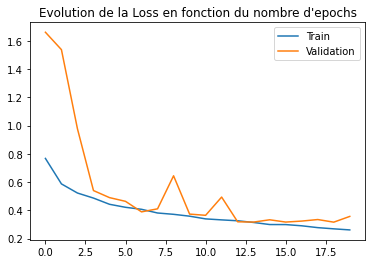

In [ ]:
plot_loss(entree=history)

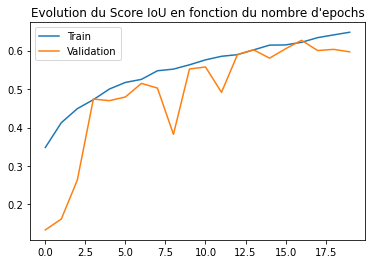

In [ ]:
plot_iou(entree=history)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  31059592


#### Temps de calcul = 2h 41mns

#### Conclusion :
- Le score IoU sur le jeu de validation est de 0.59
- Il y a une tendance d'overfitting
> **Nous allons essayer de l'améliorer**

>## <span style='color:#CA0000' id="section_5_1_2">5.1.2. Architecture U-Net `&` Avec augmentation des données `Version SOFT` <br>$~~~~~~~~~$ Fonction de perte = "Categorical Cross Entropy" </span>

- Dans ce modèle, nous avons ajouté la première version de l'augmentation d'images

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_aug(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, augmentation_sequence=img_aug_v1())
val_gen = DataGeneratorKeras_aug(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, augmentation_sequence=None)


## Compilation du modèle

In [ ]:
model_unet_augv1 = get_unet_model(img_size=img_size, num_cats=num_cats)

model_unet_augv1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[sm.metrics.iou_score])

nb_params = model_unet_augv1.count_params()

## Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-fs-unet-aug_v1.h5', save_best_only=True, verbose=1)
]


## Entraînement du modèle

In [ ]:
# Entrainement        
history = model_unet_augv1.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.8270 - iou_score: 0.3187
Epoch 1: val_loss improved from inf to 1.51698, saving model to checkpoint-fs-unet-aug_v1.h5
148/148 [==============================] - 1826s 11s/step - loss: 0.8270 - iou_score: 0.3187 - val_loss: 1.5170 - val_iou_score: 0.2116 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.6111 - iou_score: 0.4010
Epoch 2: val_loss improved from 1.51698 to 0.93868, saving model to checkpoint-fs-unet-aug_v1.h5
148/148 [==============================] - 367s 2s/step - loss: 0.6111 - iou_score: 0.4010 - val_loss: 0.9387 - val_iou_score: 0.2348 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.5726 - iou_score: 0.4224
Epoch 3: val_loss improved from 0.93868 to 0.86250, saving model to checkpoint-fs-unet-aug_v1.h5
148/148 [==============================] - 363s 2s/step - loss: 0.5726 - iou_score: 0.4224 - val_loss: 0.8625 - val_iou_score:

In [ ]:
# Sauvegarde du modèle
model_unet_augv1.save('./outputs/model-fs-unet-aug_v1.h5')

#### Résultats

In [ ]:
entree = history

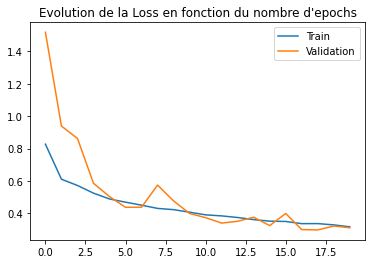

In [ ]:
plot_loss(entree)

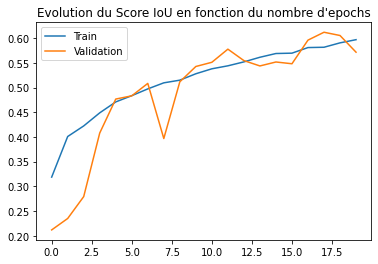

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  31059592


#### Temps de calcul = 2h 25mns

#### Conclusion :
- Ce modèle est un peu moins performant que le précédent
- Le score IoU sur le jeu de validation a diminué à 0.57
- Il n'y a pas d'overfitting
- **L'augmentation des images a donc été bénéfique pour l'apprentissage**

>## <span style='color:#CA0000' id="section_5_1_3">5.1.3. Architecture U-Net `&` Avec augmentation des données `Version HARD` <br>$~~~~~~~~~$Fonction de perte = "Categorical Cross Entropy"   </span>

- Dans ce modèle, nous avons utilisé la seconde version de l'augmentation d'images (plus conséquente que la première)

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_aug(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, augmentation_sequence=img_aug_v2())
val_gen = DataGeneratorKeras_aug(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, augmentation_sequence=None)

## Compilation du modèle

In [ ]:
model_unet_aug_v2 = get_unet_model(img_size=img_size, num_cats=num_cats)

model_unet_aug_v2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[sm.metrics.iou_score])

nb_params = model_unet_aug_v2.count_params()

In [ ]:
model_unet_aug_v2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpont-fs-unet-aug_v2.h5', save_best_only=True, verbose=1)
]

## Entraînement du modèle

In [ ]:
# Entrainement        
history = model_unet_aug_v2.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 1.1534 - iou_score: 0.2025
Epoch 1: val_loss improved from inf to 11.44547, saving model to checkpont-fs-unet-aug_v2.h5
148/148 [==============================] - 1381s 9s/step - loss: 1.1534 - iou_score: 0.2025 - val_loss: 11.4455 - val_iou_score: 0.0244 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.9402 - iou_score: 0.2541
Epoch 2: val_loss improved from 11.44547 to 4.54820, saving model to checkpont-fs-unet-aug_v2.h5
148/148 [==============================] - 442s 3s/step - loss: 0.9402 - iou_score: 0.2541 - val_loss: 4.5482 - val_iou_score: 0.0735 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.8869 - iou_score: 0.2749
Epoch 3: val_loss improved from 4.54820 to 0.93839, saving model to checkpont-fs-unet-aug_v2.h5
148/148 [==============================] - 463s 3s/step - loss: 0.8869 - iou_score: 0.2749 - val_loss: 0.9384 - val_iou_score: 

In [ ]:
# Sauvegarde du modèle
model_unet_aug_v2.save('./outputs/model-fs-unet-aug_v2.h5')

#### Résultats

In [ ]:
entree = history

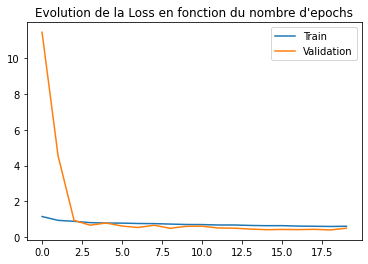

In [ ]:
# Graphiques
plot_loss(entree)

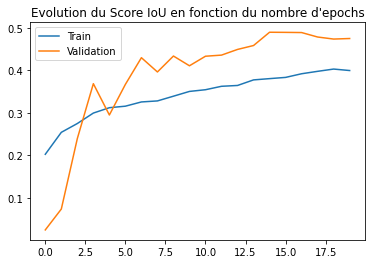

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  31059592


#### Temps de calcul = 3h 16mns

#### Conclusion :
- Ce modèle est nettement moins bon que les précédents
- Le score IoU sur le jeu de validation a diminué de façon importante à 0.47
- On peut en conclure qu'une transformation modérée des images est bénéfique pour l'apprentissage mais qu'une transformation top conséquente est dévaforable pour l'apprentissage
- Cela peut s'expliquer par le fait que la première version modérée effectue une transformation de l'image mais tout en gardant sa structure, alors que la seconde version 'destructure' l'image comme nous l'avons vu sur l'exemple ci-dessus
- **Nous retenons donc la première version de l'augmentation pour les prochains modèles**
> **Le meilleur modèle à ce stade est le modèle U-Net avec augmentation première version "SOFT"**

>## <span style='color:green' id="section_5_2" >5.2 Modélisation avec la librairie 'segmentation-models'</span>
>## <span style='color:green' >Avec augmentation des données `Version SOFT`</span>

>## <span style='color:#CA0000' id="section_5_2_1">5.2.1. Architecture U-Net `&` Fonction de perte = "Categorical Cross Entropy" <br>$~~~~~~~~$ `&` Backbone = VGGNet</span>
- avec augmentation des données
- Ce modèle est une architecture Unet implémentée avec la librairie segmentation-model
- Les poids sont initialisés aléatoirement

### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))


## Compilation du modèle

In [ ]:
# Modèle
model_unet_vgg1 = sm.Unet(BACKBONE, classes=num_cats, activation='softmax', encoder_weights=None)

model_unet_vgg1.compile('Adam', loss="categorical_crossentropy", metrics=[sm.metrics.iou_score])

nb_params = model_unet_vgg1.count_params()

In [ ]:
model_unet_vgg1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-unet-aug-vgg.h5', save_best_only=True, verbose=1)
]

### Entraînement du modèle

In [ ]:
# Entrainement    
history = model_unet_vgg1.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 1.0303 - iou_score: 0.2390
Epoch 1: val_loss improved from inf to 1.43195, saving model to checkpoint-sm-unet-aug-vgg.h5
148/148 [==============================] - 1459s 8s/step - loss: 1.0303 - iou_score: 0.2390 - val_loss: 1.4319 - val_iou_score: 0.1555 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.6725 - iou_score: 0.3651
Epoch 2: val_loss did not improve from 1.43195
148/148 [==============================] - 341s 2s/step - loss: 0.6725 - iou_score: 0.3651 - val_loss: 1.4811 - val_iou_score: 0.2292 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.6227 - iou_score: 0.3900
Epoch 3: val_loss improved from 1.43195 to 0.60860, saving model to checkpoint-sm-unet-aug-vgg.h5
148/148 [==============================] - 343s 2s/step - loss: 0.6227 - iou_score: 0.3900 - val_loss: 0.6086 - val_iou_score: 0.4003 - lr: 0.0010
Epoch 4/20
148/148 [========

In [ ]:
# Sauvegarde du modèle
model_unet_vgg1.save('./outputs/model-sm-unet-augV1-vgg.h5')

#### Résultats

In [ ]:
entree = history

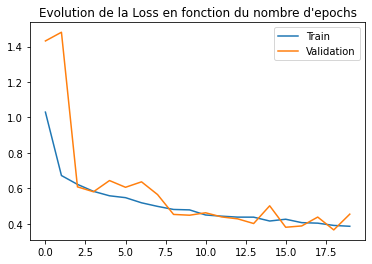

In [ ]:
plot_loss(entree)

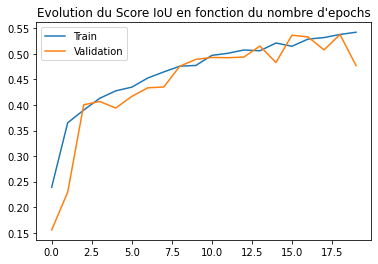

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  23753288


#### Temps de calcul = 2h 20mns

#### Conclusion :
- Ce modèle est globalement en ligne avec le précédent
- Le score IoU sur le jeu de validation est un peu inférieur, mais le temps de calcul est également inférieur et il y a moins de paramètre
- Il n'y a pas d'overfitting

>## <span style='color:#CA0000' id="section_5_2_2">5.2.2. Architecture UNet `&` Fonction de perte = "Categorical Cross Entropy" <br>$~~~~~~~~~$ `&` Backbone = VGGNet + Poids Imagenet</span>

- Ce modèle reprend le précédent mais cette fois-ci les poids sont initialisés avec un pré entraînement sur le jeu de données Imagenet (application de Transfer Learning)

### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)


#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))

## Compilation du modèle

In [ ]:
# Modèle
model_unet_vgg_imgnet = sm.Unet(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_unet_vgg_imgnet.compile('Adam', loss="categorical_crossentropy", metrics=[sm.metrics.iou_score])

nb_params = model_unet_vgg_imgnet.count_params()


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_unet_vgg_imgnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-unet-aug-vgg-imagenet.h5', save_best_only=True, verbose=1)
]

## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_unet_vgg_imgnet.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.9615 - iou_score: 0.2510
Epoch 1: val_loss improved from inf to 1.40131, saving model to checkpoint-sm-unet-aug-vgg-imagenet.h5
148/148 [==============================] - 379s 2s/step - loss: 0.9615 - iou_score: 0.2510 - val_loss: 1.4013 - val_iou_score: 0.2186 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.6188 - iou_score: 0.3872
Epoch 2: val_loss improved from 1.40131 to 0.83351, saving model to checkpoint-sm-unet-aug-vgg-imagenet.h5
148/148 [==============================] - 363s 2s/step - loss: 0.6188 - iou_score: 0.3872 - val_loss: 0.8335 - val_iou_score: 0.3108 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.5521 - iou_score: 0.4285
Epoch 3: val_loss improved from 0.83351 to 0.57328, saving model to checkpoint-sm-unet-aug-vgg-imagenet.h5
148/148 [==============================] - 350s 2s/step - loss: 0.5521 - iou_score: 0.4285 - val_l

In [ ]:
# Sauvegarde du modèle
model_unet_vgg_imgnet.save('./outputs/model-sm-unet-aug-vgg-imagenet.h5')

#### Résultats

In [ ]:
entree = history

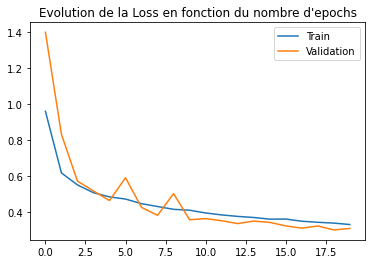

In [ ]:
# Graphiques
plot_loss(entree)

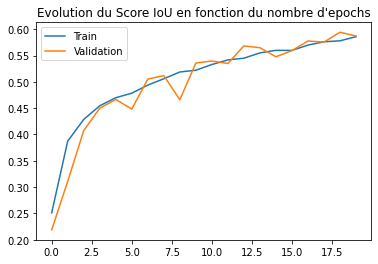

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  23753288


#### Temps de calcul = de 01h58

#### Conclusion :
- Ce modèle est supérieur au précédent
- Le score IoU sur le jeu de validation a progressé à 0.58, le temps d'exécution a diminué alors que le nombre de paramètres est resté le même.
- Il n'y a pas d'overfitting
> **C'est à ce stade le meilleur modèle**

>## <span style='color:green' id="section_5_3" >5.3 Optimisation des hyperparamètres</span>

- Afin d'améliorer le modèle, nous avons optimisé les hyper paramètres suivants :
    - Fonction de perte
    - Backbone
    - Architecture du réseau

### Optimisation de la fonction de perte
- La fonction de perte ‘classique’ pour les modèles de classification à plusieurs catégories est la Categorical Cross Entropy
- Cette fonction de perte n'est pas bien adaptée à la segmentation d'images, notamment car elle n'est pas adaptée aux jeux de données déséquilibrés 
- La fonction Dice Loss est beaucoup plus adaptée et utilisée pour la segmentation
- Cette fonction de perte est calculée à partir du coefficient Dice qui est égal à deux fois la zone de chevauchement entre la prédiction et la réalité divisé par le nombre total de pixels de l’image et du masque
- Nous avons donc testé cette fonction de perte **Dice Loss**

###  Optimisation du Backbone
- Nous avons testé les Backbone suivants :
    - Backbone **Resnet**
    - Backbone **Efficientnet**

###  Optimisation de l'architecture du réseau
- Nous avons testé les architectures de réseau suivantes :
    - Architecture **FPN (Features Pyramid Network)**
    - Architecture **Linknet**

>## <span style='color:#CA0000' id="section_5_3_1">5.3.1. Optimisation de la fonction de perte</span>

>## <span style='color:#038092' id="section_5_3_1_1">a) Architecture Unet `&` Fonction de perte = "Dice Loss"  <br> $~~~~~~$ `&` Backbone = VGGNet + Poids Imagenet</span>

- Dans ce modèle nous avons remplacé la fonction de perte Categorical Cross Entropy par la fonction de perte Dice Loss

### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))

## Compilation du modèle

In [ ]:
# Modèle
model_unet_diceloss_imgnet = sm.Unet(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_unet_diceloss_imgnet.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

nb_params = model_unet_diceloss_imgnet.count_params()

58900480/58889256 [==============================] - 2s 0us/step


### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-unet-aug-vgg-imagenet-diceloss.h5', save_best_only=True, verbose=1)
]

In [ ]:
model_unet_diceloss_imgnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_unet_diceloss_imgnet.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.5212 - iou_score: 0.3695
Epoch 1: val_loss improved from inf to 0.57824, saving model to checkpoint-sm-unet-aug-vgg-imagenet-diceloss.h5
148/148 [==============================] - 1814s 11s/step - loss: 0.5212 - iou_score: 0.3695 - val_loss: 0.5782 - val_iou_score: 0.3169 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.3539 - iou_score: 0.5235
Epoch 2: val_loss improved from 0.57824 to 0.51107, saving model to checkpoint-sm-unet-aug-vgg-imagenet-diceloss.h5
148/148 [==============================] - 350s 2s/step - loss: 0.3539 - iou_score: 0.5235 - val_loss: 0.5111 - val_iou_score: 0.3645 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.3142 - iou_score: 0.5618
Epoch 3: val_loss improved from 0.51107 to 0.32533, saving model to checkpoint-sm-unet-aug-vgg-imagenet-diceloss.h5
148/148 [==============================] - 350s 2s/step - loss: 0.314

In [ ]:
# Sauvegarde du modèle
model_unet_diceloss_imgnet.save('./outputs/model-sm-unet-aug-vgg-imagenet-diceloss.h5')

#### Résultats

In [ ]:
entree = history

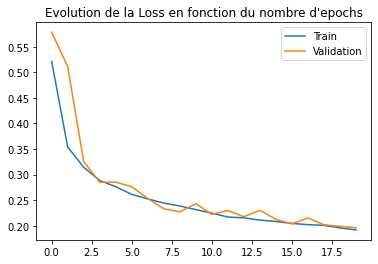

In [ ]:
plot_loss(entree)

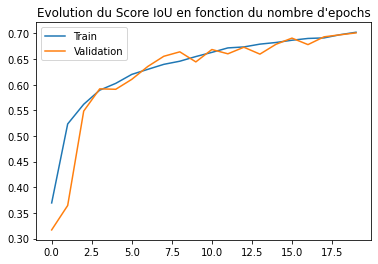

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  23753288


#### Temps de calcul = 2h 18mns

#### Conclusion :
- **La modification de la fonction de perte a été très bénéfique**
- Le score IoU sur le jeu de validation a nettement augmenté à 0.7 et est supérieur à celui des précédents modèles
- Le nombre de paramètre est stable
- Le temps d'éxécution est légèrement supérieur au précédent
- Il n'y a pas d'overfitting (écart de l'ordre de 0.001 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
> **C'est le meilleur modèle à ce stade**

>## <span style='color:#CA0000' id="section_5_3_2">5.3.2. Optimisation du Backbone</span>

>## <span style='color:#038092' id="section_5_3_1_2">a) Architecture Unet `&` Fonction de perte = "Dice Loss"<br> $~~~~~~$ `&` Backbone = Resnet + Poids Imagenet</span>
- Dans ce modèle nous avons changé le backbone pour un backbone Resnet

#### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))

## Compilation du modèle

In [ ]:
# Modèle
model_unet_resnet = sm.Unet(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_unet_resnet.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

nb_params = model_unet_resnet.count_params()

85532672/85521592 [==============================] - 3s 0us/step


### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-unet-aug-resnet-imagenet-diceloss.h5', save_best_only=True, verbose=1)
]

In [ ]:
model_unet_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_unet_resnet.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.4656 - iou_score: 0.4244
Epoch 1: val_loss improved from inf to 0.68270, saving model to checkpoint-sm-unet-aug-resnet-imagenet-diceloss.h5
148/148 [==============================] - 367s 2s/step - loss: 0.4656 - iou_score: 0.4244 - val_loss: 0.6827 - val_iou_score: 0.2173 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.3066 - iou_score: 0.5768
Epoch 2: val_loss improved from 0.68270 to 0.34377, saving model to checkpoint-sm-unet-aug-resnet-imagenet-diceloss.h5
148/148 [==============================] - 338s 2s/step - loss: 0.3066 - iou_score: 0.5768 - val_loss: 0.3438 - val_iou_score: 0.5371 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.2784 - iou_score: 0.6045
Epoch 3: val_loss improved from 0.34377 to 0.29971, saving model to checkpoint-sm-unet-aug-resnet-imagenet-diceloss.h5
148/148 [==============================] - 336s 2s/step - loss

In [ ]:
# Sauvegarde du modèle
model_unet_resnet.save('./outputs/model-sm-unet-aug-resnet-imagenet-diceloss.h5')

#### Résultats

In [ ]:
entree = history

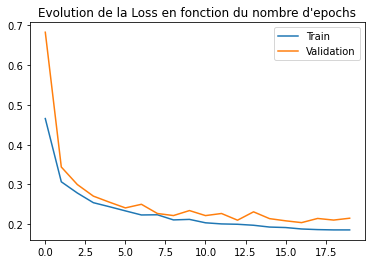

In [ ]:
# Graphiques
plot_loss(entree)

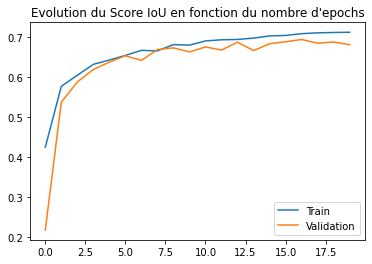

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  24457169


#### Temps de calcul = 01h55

#### Conclusion :
- **La modification du backbone a été très bénéfique : le backbone Resnet a amélioré l'apprentissage mais on voit un léger overfitting**
- Le score IoU sur le jeu de validation a démunué à 0.68
- Le temps d'exécution a dimunué 
- Le nombre de paramètres a augmenté
- Il n'y a pas d'overfitting (écart de seulement 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)

>## <span style='color:#038092' id="section_5_3_1_3">b) Architecture Unet `&` Fonction de perte = "Dice Loss" <br> $~~~~~~$ `&` Backbone = Efficientnet + Poids Imagenet</span>
- Dans ce modèle nous avons changé le backbone pour un backbone Efficientnet

#### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))


## Compilation du modèle

In [ ]:
# Modèle
model_unet_efficientnet = sm.Unet(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_unet_efficientnet.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

nb_params = model_unet_efficientnet.count_params()

44122112/44107200 [==============================] - 1s 0us/step


### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-unet-aug-efficientnet-imagenet-diceloss.h5', save_best_only=True, verbose=1)
]

In [ ]:
model_unet_efficientnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_unet_efficientnet.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.4236 - iou_score: 0.4652 
Epoch 1: val_loss improved from inf to 0.44903, saving model to checkpoint-sm-unet-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 2736s 18s/step - loss: 0.4236 - iou_score: 0.4652 - val_loss: 0.4490 - val_iou_score: 0.4158 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.2713 - iou_score: 0.6148
Epoch 2: val_loss improved from 0.44903 to 0.28860, saving model to checkpoint-sm-unet-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 377s 3s/step - loss: 0.2713 - iou_score: 0.6148 - val_loss: 0.2886 - val_iou_score: 0.6067 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.2396 - iou_score: 0.6467
Epoch 3: val_loss improved from 0.28860 to 0.25599, saving model to checkpoint-sm-unet-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] 

In [ ]:
# Sauvegarde du modèle
model_unet_efficientnet.save('./outputs/model-sm-unet-aug-efficientnet-imagenet-diceloss.h5')

#### Résultats

In [ ]:
entree = history

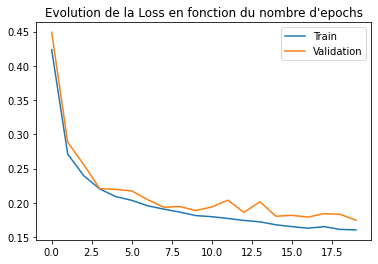

In [ ]:
# Graphiques
plot_loss(entree)

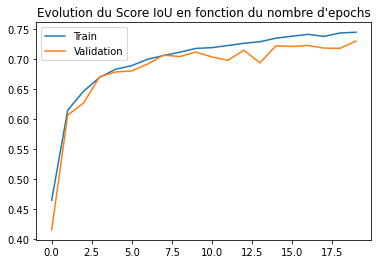

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  17868848


#### Temps de calcul = 2h41

#### Conclusion :
- **La modification du backbone a été très bénéfique : le backbone Efficientnet a amélioré l'apprentissage**
- Le score IoU sur le jeu de validation a progressé à 0.73
- Le temps d'exécution ainsi que le nombre de paramètres ont diminué
- Il n'y a pas d'overfitting (écart de l'ordre de 0.01 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
> **C'est le meilleur modèle à ce stade**

>## <span style='color:#CA0000' id="section_5_3_3">5.3.3. Optimisation de l'archictures du réseau</span>
>## <span style='color:#038092' id="section_5_3_3_1">a) Architecture FPN `&` Fonction de perte = "Dice Loss"  <br> $~~~~~~$ `&` Backbone = Efficientnet + Poids Imagenet</span>

- Dans ce modèle nous avons changé l'architecture pour une architecture de type FPN (Features Pyramid Network)

#### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)


#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))

## Compilation du modèle

In [ ]:
# Modèle
model_fpn_imgnet = sm.FPN(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_fpn_imgnet.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

nb_params = model_fpn_imgnet.count_params()

In [ ]:
model_fpn_imgnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

### Les Callbacks

In [ ]:
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-fpn-aug-efficientnet-imagenet-diceloss.h5', save_best_only=True, verbose=1)
]


## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_fpn_imgnet.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.3088 - iou_score: 0.5738
Epoch 1: val_loss improved from inf to 0.28375, saving model to checkpoint-sm-fpn-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 423s 3s/step - loss: 0.3088 - iou_score: 0.5738 - val_loss: 0.2837 - val_iou_score: 0.6004 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.2369 - iou_score: 0.6502
Epoch 2: val_loss improved from 0.28375 to 0.25603, saving model to checkpoint-sm-fpn-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 376s 3s/step - loss: 0.2369 - iou_score: 0.6502 - val_loss: 0.2560 - val_iou_score: 0.6344 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.2173 - iou_score: 0.6731
Epoch 3: val_loss improved from 0.25603 to 0.21453, saving model to checkpoint-sm-fpn-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 372s

In [ ]:
# Sauvegarde du modèle
model_fpn_imgnet.save('./outputs/model-sm-fpn-aug-efficientnet-imagenet-diceloss.h5')

#### Résultats

In [ ]:
entree = history

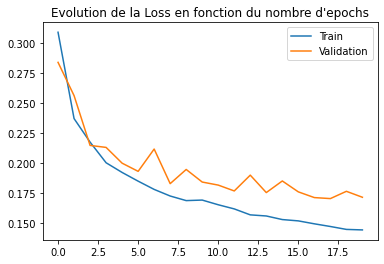

In [ ]:
plot_loss(entree)

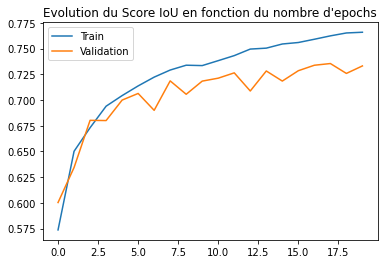

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  13919792


#### Temps de calcul = 2h08

#### Conclusion :
- **La modification de l'architecture a été bénéfique : l'architecture FPN a amélioré l'apprentissage**
- Le score IoU sur le jeu de validation a progressé à 0.733
- Le nombre de paramètres a diminué
- Le temps d'exécution (2h08mns) est largement inférieur au précédent (2h41mns)
- Il n'y a pas d'overfitting (écart de l'ordre de 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
> **C'est le meilleur modèle à ce stade**

>## <span style='color:#038092' id="section_5_3_3_1">a) Architecture LinkNet `&` Fonction de perte = "Dice Loss" <br> $~~~~~~$ `&` Backbone = Efficientnet + Poids Imagenet </span>
- Dans ce modèle nous avons changé l'architecture pour une architecture de type Linknet

#### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))


## Compilation du modèle

In [ ]:
# Modèle
model_linknet_imgnet = sm.Linknet(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_linknet_imgnet.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

nb_params = model_linknet_imgnet.count_params()


44122112/44107200 [==============================] - 1s 0us/step


### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-sm-linknet-aug-efficientnet-imagenet-diceloss.h5', save_best_only=True, verbose=1)
]


In [ ]:
model_linknet_imgnet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_linknet_imgnet.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.4487 - iou_score: 0.4434
Epoch 1: val_loss improved from inf to 0.61792, saving model to checkpoint-sm-linknet-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 1696s 9s/step - loss: 0.4487 - iou_score: 0.4434 - val_loss: 0.6179 - val_iou_score: 0.2601 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.2689 - iou_score: 0.6155
Epoch 2: val_loss improved from 0.61792 to 0.27417, saving model to checkpoint-sm-linknet-aug-efficientnet-imagenet-diceloss.h5
148/148 [==============================] - 359s 2s/step - loss: 0.2689 - iou_score: 0.6155 - val_loss: 0.2742 - val_iou_score: 0.6190 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.2328 - iou_score: 0.6564
Epoch 3: val_loss improved from 0.27417 to 0.23207, saving model to checkpoint-sm-linknet-aug-efficientnet-imagenet-diceloss.h5
148/148 [=========================

In [ ]:
# Sauvegarde du modèle
model_linknet_imgnet.save('./outputs/model-sm-linknet-aug-efficientnet-imagenet-diceloss.h5')

#### Résultats

In [ ]:
entree = history

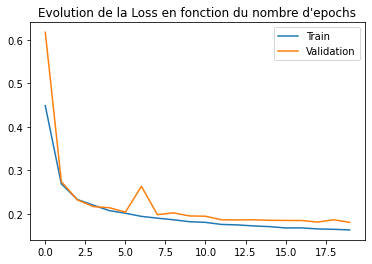

In [ ]:
plot_loss(entree)

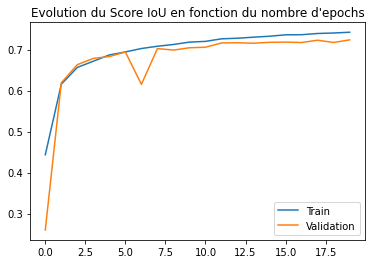

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  13762000


#### Temps de calcul = 2h 23min

#### Conclusion :
- Ce modèle est un peu moins bon que le précédent
- Le score IoU sur le jeu de validation a diminué à 0.723
- Le temps d'exécution a augmenté
- Le nombre de paramètres est du même ordre
- Il n'y a pas d'overfitting (écart de l'ordre de 0.02 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)

>## <span style='color:#CA0000' id="section_5_3_4">5.3.4. Meilleur modèle</span>

- Le meilleur modèle retenu est le suivant : 
    - **Augmentation des données version 1**
    - Fonction de perte **DiceLoss**
    - Backbone **Efficientnet** avec poids pré entrainés **Imagenet**
    - Architecture **FPN**
    
    
- On peut noter que **ce modèle améliore nettement le modèle de référence** :
    - Le score IoU a progressé de 0.57 pour le modèle de référence à 0.733 pour le modèle optimisé
    - Le temps d'exécution a diminué de 2h25mns pour le modèle de référence à 2h08mns pour le modèle optimisisé

>## <span style='color:#038092' id="section_5_3_4_1">a) Meilleur modèle entrainé sur des images de dimensions (256, 512)</span>
- Pour terminer la phase de modélisation, nous avons entrainé le meilleur modèle sur des images de plus grandes dimensions

#### Semgentation-models configuration

In [ ]:
# Semgentation-models configuration
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)


In [ ]:
# Paramètres
nb_epochs = 20
batch_size = 8
img_size = (256, 512)
num_cats = 8

#### Génération des données

In [ ]:
train_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_train_dir, mask_dataset_train_dir, img_aug_v1(), get_preprocessing(preprocess_input))
val_gen = DataGeneratorKeras_augm_preproc(batch_size, img_size, image_dataset_val_dir, mask_dataset_val_dir, None, get_preprocessing(preprocess_input))

## Compilation du modèle

In [ ]:
# Modèle
model_best = sm.FPN(BACKBONE, classes=num_cats, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

model_best.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

nb_params = model_best.count_params()


44122112/44107200 [==============================] - 3s 0us/step


### Les Callbacks

In [ ]:
# Callbacks
callbacks=[
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('checkpoint-best-model.h5', save_best_only=True, verbose=1)
]


## Entraînement du modèle

In [ ]:
# Entrainement    
history = model_best.fit(train_gen, epochs=nb_epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
297/297 [==============================] - ETA: 0s - loss: 0.2585 - iou_score: 0.6284
Epoch 1: val_loss improved from inf to 0.22614, saving model to checkpoint-best-model.h5
297/297 [==============================] - 2015s 7s/step - loss: 0.2585 - iou_score: 0.6284 - val_loss: 0.2261 - val_iou_score: 0.6712 - lr: 0.0010
Epoch 2/20
297/297 [==============================] - ETA: 0s - loss: 0.1946 - iou_score: 0.7017
Epoch 2: val_loss improved from 0.22614 to 0.19505, saving model to checkpoint-best-model.h5
297/297 [==============================] - 483s 2s/step - loss: 0.1946 - iou_score: 0.7017 - val_loss: 0.1950 - val_iou_score: 0.7026 - lr: 0.0010
Epoch 3/20
297/297 [==============================] - ETA: 0s - loss: 0.1759 - iou_score: 0.7251
Epoch 3: val_loss improved from 0.19505 to 0.17789, saving model to checkpoint-best-model.h5
297/297 [==============================] - 481s 2s/step - loss: 0.1759 - iou_score: 0.7251 - val_loss: 0.1779 - val_iou_score: 0.7256 - lr:

In [ ]:
# Sauvegarde du modèle
model_best.save('./outputs/model-best-model.h5')

#### Résultats

In [ ]:
entree = history

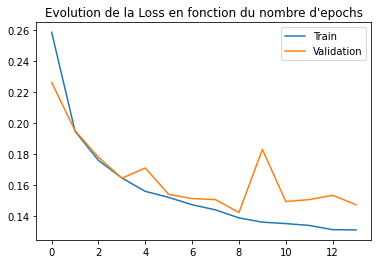

In [ ]:
plot_loss(entree)

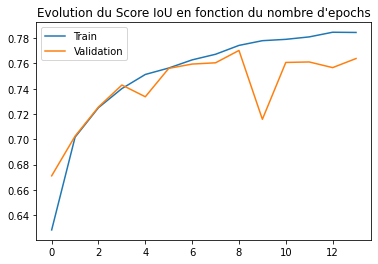

In [ ]:
plot_iou(entree)

In [ ]:
print('Nombre de paramètres du réseau : ', nb_params)

Nombre de paramètres du réseau :  13919792


#### Temps de calcul = 2h17mns

#### Conclusion :
- L'augmentation de la taille des images a amélioré le résultat
- Le score IoU sur le jeu de validation a nettement augmenté à 0.764
- Il n'y a pas d'overfitting (écart de seulement 0.02 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)

## Conclusion de la modélisation :
- Nous obtenons un **score IoU sur le jeu de validation de 0.76**, ce qui peut être considéré comme un **très bon résultat**

# <span style='color:blue' id="section_6" >6. Evaluation du meilleur modèle sur le jeu de Test</span>

## Chargement du meilleur modèle

In [12]:
best_model_name = 'model-best-model.h5'
custom_objects = {'iou_score': sm.metrics.iou_score, 'dice_loss': sm.losses.dice_loss}
best_model_path = drive_path + 'outputs/'
best_model = best_model_path + best_model_name
best_model = load_model(best_model, custom_objects=custom_objects)

## Générateur et pre processing pour le jeu de test

In [13]:
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [14]:
#Fonction de preprocessing
def get_preprocessing(preprocessing_fn):   
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [15]:
# Génération des données
class DataGeneratorKeras(Sequence):

    def __init__(self, batch_size, img_size, input_img_dir, target_img_dir, preprocessing):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_dir = input_img_dir
        self.input_img_paths = sorted(os.listdir(input_img_dir))
        self.target_img_dir = target_img_dir
        self.target_img_paths = sorted(os.listdir(target_img_dir))
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
                
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="float32")
        
        #traitement des images
        for j, input_path in enumerate(sorted(batch_input_img_paths)):
            img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
            img_array = img_to_array(img)
            preprocessed_image = self.preprocessing(image=img_array)
            x[j] = preprocessed_image['image']
        
        #traitement des masques
        for j, target_path in enumerate(sorted(batch_target_img_paths)):
            mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
            mask_array = np.squeeze(img_to_array(mask))
            y[j] = tf.one_hot(mask_array, 8, on_value=1.0, off_value=0.0, axis=-1)

        return x, y

In [16]:
image_dataset_test_dir = drive_path + 'prepared_data/images/test'
mask_dataset_test_dir = drive_path + 'prepared_data/masks_traites/test'

In [17]:
img_size = (256, 512)

In [18]:
test_gen = DataGeneratorKeras(5, img_size, image_dataset_test_dir, mask_dataset_test_dir, get_preprocessing(preprocess_input))

## Prédictions sur le jeu de test

In [19]:
test_predictions = best_model.predict(test_gen, verbose=1)

100/100 [==============================] - 195s 2s/step


## Calcul du Score IoU sur le jeu de test

In [20]:
masks_predicted_array = np.argmax(test_predictions, axis=-1)

In [21]:
masks_to_predict_array = np.zeros(masks_predicted_array.shape, dtype="int64")

In [22]:
for i, img in enumerate(sorted(os.listdir(mask_dataset_test_dir))):
    mask_load = load_img(os.path.join(mask_dataset_test_dir, img), target_size=img_size)
    mask_array = img_to_array(mask_load)
    masks_to_predict_array[i]=mask_array[:,:,0]

In [23]:
m = tf.keras.metrics.MeanIoU(num_classes=8)
m.update_state(masks_to_predict_array, masks_predicted_array)
test_score_iou = m.result().numpy()

In [24]:
print(f'Score IoU sur le jeu de test = {test_score_iou:.3f}')

Score IoU sur le jeu de test = 0.762


## Conclusion de l'évaluation sur le jeu de test :
- On obtient un score IoU sur le jeu de test égal à 0.762
- Ce score est presque égale à celui obtenu lors de la modélisation sur le jeu de validation (0.764) 
- **Cela montre la qualité et la bonne capacité de généralisation de notre modèle**